<a href="https://colab.research.google.com/github/Severus-Reddy/Personality-Classification-using-MBTI/blob/main/Personality_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import pickle
import os.path
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.express as graph
import spacy
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Load one of the availables trained pipelines for English
# English pipeline optimized for CPU. Components: tok2vec, tagger, parser, senter, ner, attribute_ruler, lemmatizer.
nlp = spacy.load('en_core_web_sm')


# stop words built in spacy (english)
print(nlp.Defaults.stop_words)

{'indeed', 'however', 'nor', 'empty', 'already', 'even', 'done', 'ourselves', 'why', 'since', 'go', 'unless', 'thereupon', 'then', 'our', 'somehow', 'whereupon', 'somewhere', 'whom', 'be', 'make', 'whose', 'still', 'twenty', 'otherwise', 'really', 'could', 'first', 'others', 'a', 'hereby', 'throughout', 'through', 'every', 're', 'all', 'either', 'whence', 'his', 'while', '‘ve', 'yourself', 'him', 'and', 'can', 'another', 'any', 'fifteen', 'himself', 'sometime', 'that', 'this', 'whither', 'hereafter', 'has', 'third', 'between', 'ever', 'thereby', 'have', 'anyhow', 'thereafter', 'sixty', 'via', '‘re', 'further', 'something', 'the', '’ll', 'serious', 'enough', 'although', 'had', 'thence', 'its', 'myself', 'same', 'rather', "'ll", 'into', 'up', 'anyone', 'such', 'around', 'moreover', '’re', 'move', 'she', 'as', 'once', 'show', 'who', "'ve", 'being', 'less', 'get', 'on', 'last', "'m", 'may', 'everyone', 'forty', 'five', 'about', 'whatever', 'i', '’d', 'part', 'herself', 'doing', 'what', 'n‘

In [3]:
print(f"Number of default stop words : {len(nlp.Defaults.stop_words)}")

Number of default stop words : 326


In [4]:
# Checking if a word is a stop word
nlp.vocab['is'].is_stop

True

In [5]:
nlp.vocab['below'].is_stop

True

In [6]:
nlp.vocab['btw'].is_stop

False

In [7]:
s_stemmer = SnowballStemmer(language='english')

In [8]:
words = ['run', 'runner', 'ran', 'runs', 'easily', 'fairly', 'fairness','boats','boating']

In [9]:
for word in words:
    print(word+ ' ------> ' + s_stemmer.stem(word))

run ------> run
runner ------> runner
ran ------> ran
runs ------> run
easily ------> easili
fairly ------> fair
fairness ------> fair
boats ------> boat
boating ------> boat


In [10]:
# Function to display lemmas
def show_lemmas(text):
    for token in text:
        print(f'{token.text:{12}} {token.pos_:{6}} {token.lemma:<{22}} {token.lemma_}')

In [11]:
# Function to display lemmas
def show_lemmas(text):
    for token in text:
        print(f'{token.text:{12}} {token.pos_:{6}} {token.lemma:<{22}} {token.lemma_}')

In [12]:
doc = nlp(u"I am meeting him tomorrow at the meeting.")
show_lemmas(doc)

I            PRON   4690420944186131903    I
am           AUX    10382539506755952630   be
meeting      VERB   6880656908171229526    meet
him          PRON   1655312771067108281    he
tomorrow     NOUN   3573583789758258062    tomorrow
at           ADP    11667289587015813222   at
the          DET    7425985699627899538    the
meeting      NOUN   14798207169164081740   meeting
.            PUNCT  12646065887601541794   .


In [13]:
count_vect = CountVectorizer()

In [14]:
phrase = ["I'd like to have a glass of water please"]

In [15]:
# Fit Vectorizer to the Data (build a vocab, count the number of words...)
# Learn a vocabulary dictionary of all tokens in the raw documents
count_vect.fit(phrase)

CountVectorizer()

In [16]:
# Show features
count_vect.get_feature_names()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



['glass', 'have', 'like', 'of', 'please', 'to', 'water']

In [17]:
# Learn the vocabulary dictionary and return document-term matrix
count_vect.fit_transform(phrase)

<1x7 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [18]:
# shows a mapping of terms to feature indices.
count_vect.vocabulary_

{'like': 2, 'to': 5, 'have': 1, 'glass': 0, 'of': 3, 'water': 6, 'please': 4}

In [19]:
df = pd.read_csv('/content/gdrive/MyDrive/MBTI 500.csv')

In [20]:
df.head()

,posts,type
0,know intj tool use interaction people excuse a...,INTJ
1,rap music ehh opp yeah know valid well know fa...,INTJ
2,preferably p hd low except wew lad video p min...,INTJ
3,drink like wish could drink red wine give head...,INTJ
4,space program ah bad deal meing freelance max ...,INTJ


In [21]:
df['posts'][0]

'know intj tool use interaction people excuse antisocial truly enlighten mastermind know would count pet peeze something time matter people either whether group people mall never see best friend sit outside conversation jsut listen want interject sit formulate say wait inject argument thought find fascinate sit watch people talk people fascinate sit class watch different people find intrigue dad intj u stand look like line safeway watch people home talk people like think military job people voluntarily go job important show deference endanger live glorify way civilian think pretty ignorant general think military necessary defense mechanism political tactic feel like u specifically invest much money could put money education whatnot though personally sound budget aernative really comment one way base two politician eye year ago come name somewhat important kinda role model nowadays pick keep score individual level mean little vary accord number condition day may score high others low sw

In [22]:
df['type'][0]

'INTJ'

In [23]:
df['type'].unique()

array(['INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP', 'ENFJ', 'ENFP',
       'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP', 'INFJ', 'INFP'],
      dtype=object)

In [24]:
print(f"Total of {len(df['type'].unique())} types of classified MBTI posts")

Total of 16 types of classified MBTI posts


In [25]:
df.isnull().sum()

posts    0
type     0
dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)




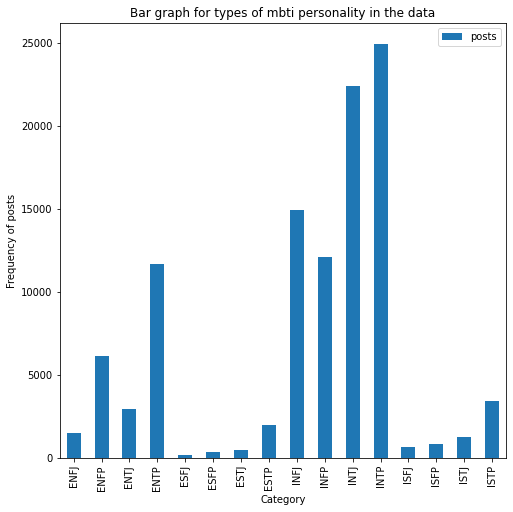

In [29]:
y = df.groupby('type').count()

print(y.plot(kind='bar',figsize=(8,8),xlabel='Category',ylabel='Frequency of posts', title='Bar graph for types of mbti personality in the data'))
print("\n")
graph.pie(df,names='type',title='Pie graph for types of mbti personality in the data', height=600, width=600)

In [31]:
df_bar_chart=df.groupby('type').count()


trace1 = go.Bar(x=df_bar_chart.index, y=df_bar_chart['posts'])

data = [trace1]
layout = go.Layout(title='MBTI # Classified Posts per Type')

fig = go.Figure(data=data, layout=layout)

fig.show()

In [32]:
# Flag to re-create or not the machine learning model
recreate_model=False

In [33]:
# We'll save the model into a file:
filename = 'mbti_svm_v2.sav'

In [34]:
# If the model file doesn't exists
if not os.path.isfile(filename):
    recreate_model=True

In [35]:
X = df['posts'] # features
y = df['type']  # labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Support Vector Classifier

In [36]:
# Check if need to recreate the model
if recreate_model:    
    
    # Creating an instance to vectorizer:
    vectorizer = TfidfVectorizer()
    
    # Training the vectorizer:
    X_train_tfidf = vectorizer.fit_transform(X_train)
    
    # Training the classifier:
    clf = LinearSVC()
    clf.fit(X_train_tfidf, y_train)
    
    # Pipelining the vectorizer and the classifier
    text_clf = Pipeline([('tfidf',TfidfVectorizer()),('clf',LinearSVC())])
    text_clf.fit(X_train, y_train)
    
    # saving the model to disk
    pickle.dump(text_clf, open(filename, 'wb'))

# If there is no need to recreate the model, just open the file from the disk    
else:
    # loading the model from disk
    text_clf = pickle.load(open(filename, 'rb'))

In [37]:
predictions = text_clf.predict(X_test)
array = set()
for i in X_test:
  array.update(i.split(" "))

In [38]:
print(array)

{'zatoichi', 'runout', 'ncrease', 'treason', 'mabibigat', 'repare', 'eceryhing', 'mormononism', 'depanding', 'mastrubation', 'assasination', 'anxeity', 'aaww', 'snipey', 'uwu', 'fulfillment', 'mysteriously', 'levity', 'proft', 'toad', 'mifepristone', 'dreamin', 'effy', 'mycelium', 'comimg', 'boyshorts', 'junjou', 'shity', 'narccicists', 'psychostick', 'honsetly', 'quarics', 'weil', 'auxilary', 'beaucoup', 'crop', 'breakcore', 'radiohead', 'springboarding', 'hots', 'grok', 'mpre', 'criminalistics', 'onscientiousness', 'menzingers', 'examsit', 'whaaaaaaaaaaat', 'interbike', 'blarghaghdqwipnks', 'ahahahahahahahhahaahh', 'chimo', 'lancome', 'sidestep', 'damian', 'fervent', 'stray', 'subvocalize', 'nizou', 'exclusvitiy', 'shrine', 'feminime', 'franco', 'microanalyze', 'undersiders', 'wellsy', 'incongruity', 'literrally', 'betty', 'enfpishness', 'clingyness', 'alaska', 'datsyuk', 'somma', 'intersectionalism', 'reasonign', 'bundesland', 'idealisits', 'sorrys', 'mijn', 'grasshopper', 'nintendo

In [39]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[ 186   13    5    6    0    0    3    0   38   28   13   19    3    2
     2    1]
 [   4  973    2   34    0    0    0    0   69   74   64   20    1    2
     3    3]
 [   0    7  459   11    1    0    0    0   11   12   51   23    1    0
     0    1]
 [   4   26    4 1924    0    0    3    2   70   32   91  150    1    0
     5   12]
 [   0    1    0    3   15    0    0    0    5    1    3    4    1    0
     0    0]
 [   0    7    2    7    0   36    0    0    3    4    9    2    1    2
     0    2]
 [   1    1    2    1    0    0   88    0    3    1    5    2    1    0
     0    0]
 [   0    1    1    6    0    0    0  357    4    4    8   11    0    1
     2    3]
 [   7   47    9   42    0    1    2    4 2489  136  112   92    2    3
     1    7]
 [   8   48    1   29    0    2    0    1  143 1968   61  110    1    5
     2   12]
 [   3   37   13   65    0    0    0    5  102   56 3940  295    0    3
     4    8]
 [   5   15   12   81    2    2    0    7   73   86  326 4399    

In [40]:
print(f"Overall accuracy of the model: {round(metrics.accuracy_score(y_test, predictions),2)}")

Overall accuracy of the model: 0.84


## Naive Bayes

In [41]:
from sklearn.naive_bayes import MultinomialNB
text_clf = Pipeline([('tfidf', TfidfVectorizer()),('clf', MultinomialNB()),])
text_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [42]:
predictions = text_clf.predict(X_test)

In [43]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[   0    0    0    0    0    0    0    0    0    0   10  309    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    1    0  133 1115    0    0
     0    0]
 [   0    0    6    0    0    0    0    0    0    0   81  490    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0   22 2302    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    2   31    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    2   73    0    0
     0    0]
 [   0    0    0    0    0    0    7    0    0    0    3   95    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0   41  357    0    0
     0    0]
 [   0    0    0    0    0    0    0    0   22    0  150 2782    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    2   38 2351    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0 1108 3423    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0   10 5023    

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00       319
        ENFP       0.00      0.00      0.00      1249
        ENTJ       1.00      0.01      0.02       577
        ENTP       0.00      0.00      0.00      2324
        ESFJ       0.00      0.00      0.00        33
        ESFP       0.00      0.00      0.00        75
        ESTJ       1.00      0.07      0.12       105
        ESTP       0.00      0.00      0.00       398
        INFJ       0.96      0.01      0.01      2954
        INFP       1.00      0.00      0.00      2391
        INTJ       0.67      0.24      0.36      4531
        INTP       0.26      1.00      0.41      5033
        ISFJ       0.00      0.00      0.00       132
        ISFP       0.00      0.00      0.00       161
        ISTJ       0.00      0.00      0.00       253
        ISTP       0.00      0.00      0.00       679

    accuracy                           0.29     21214
   macro avg       0.31   

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [44]:
print(f"Overall accuracy of the model: {round(metrics.accuracy_score(y_test, predictions),2)}")

Overall accuracy of the model: 0.29


## Logistic Regression

In [45]:
from sklearn.linear_model import LogisticRegression
text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())])
text_clf.fit(X_train, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())])

In [46]:
predictions = text_clf.predict(X_test)

In [47]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[ 175    7    6    7    0    0    3    0   49   31   15   21    2    1
     1    1]
 [   3  930    3   38    0    0    0    0   90   82   74   23    2    0
     2    2]
 [   0    5  432   22    1    0    0    0   11   12   58   34    1    0
     0    1]
 [   3   16    8 1879    0    2    0    2   80   38  104  179    0    0
     5    8]
 [   2    1    0    9    6    0    0    0    5    1    5    3    1    0
     0    0]
 [   0    3    2   14    1   25    0    0    5    7    7    6    0    3
     0    2]
 [   0    1    3    3    0    0   74    0    5    6    5    5    2    0
     1    0]
 [   0    0    0   14    0    1    0  332    6    3   18   16    1    1
     1    5]
 [  11   35    6   52    0    0    1    2 2485  142  112   96    2    5
     1    4]
 [   8   33    3   33    0    1    0    1  130 1987   60  118    0    5
     2   10]
 [   4   32   10   53    0    0    0    4   94   53 3964  306    0    3
     3    5]
 [   4    7   10   75    0    0    0    5   53   86  288 4487    

In [48]:
print(f"Overall accuracy of the model: {round(metrics.accuracy_score(y_test, predictions),2)}")

Overall accuracy of the model: 0.83


In [49]:
new_input = input("Enter some text or any post:")

Enter some text or any post:Everybody isn't your friend just because they hang around and laugh with you doesn't mean they are your friends. People pretend well... at the end of the day only yourself and family will be with u....


In [50]:
new_input = [new_input]
new_output = text_clf.predict(new_input)
print(new_input, new_output)

["Everybody isn't your friend just because they hang around and laugh with you doesn't mean they are your friends. People pretend well... at the end of the day only yourself and family will be with u...."] ['INTJ']


In [51]:
string = "".join(new_output)
print(string)
my_dict={'I':"INTROVERSION", 'E':"EXTRAVERSION",'S':"SENSING",'N':"INTUITION",'T':"THINKING",'F':"FEELING",'J':"JUDGING",'P':"PERCEIVING"}
for key in my_dict:
    if key in string:
         print(my_dict[key])

dicta={'INTJ':"Imaginative and strategic thinkers, with a plan for everything.",
      'INTP':"Innovative inventors with an unquenchable thirst for knowledge.",
      'ENTJ':"Bold, imaginative and strong-willed leaders, always finding a way – or making one.",
      'ENTP':"Smart and curious thinkers who cannot resist an intellectual challenge.",
      'INFJ':"Quiet and mystical, yet very inspiring and tireless idealists.",
      'INFP':"Poetic, kind and altruistic people, always eager to help a good cause.",
      'ENFJ':"Charismatic and inspiring leaders, able to mesmerize their listeners.",
      'ENFP':"Enthusiastic, creative and sociable free spirits, who can always find a reason to smile.",      
      'ISTJ':"Practical and fact-minded individuals, whose reliability cannot be doubted.",
      'ISFJ':"Very dedicated and warm protectors, always ready to defend their loved ones.",
      'ESTJ':"Excellent administrators, unsurpassed at managing things – or people.",
      'ESFJ':"Extraordinarily caring, social and popular people, always eager to help.",
      'ISTP':"Bold and practical experimenters, masters of all kinds of tools.",
      'ISFP':"Flexible and charming artists, always ready to explore and experience something new.",
      'ESTP':"Smart, energetic and very perceptive people, who truly enjoy living on the edge.",
      'ESFP':"Spontaneous, energetic and enthusiastic people – life is never boring around them.",}

print(dicta[string])

INTJ
INTROVERSION
INTUITION
THINKING
JUDGING
Imaginative and strategic thinkers, with a plan for everything.
